In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/consumercomplaints.csv').dropna()
data = data.drop(columns=['Unnamed: 0', 'Date received', 'Sub-product', 'Issue', 'Sub-issue'])
# data = data.drop(columns=['Unnamed: 0'])
data.head(5)

,Product,Consumer complaint narrative
3,Checking or savings account,"Hi, I have been banking with Wells Fargo for o..."
11,Debt collection,XXXX is attempting to collect funds for Valuat...
15,"Credit reporting, credit repair services, or o...",Today I called to get my balance and reset my ...
51,"Credit reporting, credit repair services, or o...",The Federal Trade Commission Bureau of Consume...
72,"Credit reporting, credit repair services, or o...",Ive mailed police report called been hung up o...


In [4]:
data.to_parquet('../Dataset/consumercomplaints_dropna_reducedcolumns.parquet')

In [12]:
# data.to_csv('../Dataset/consumercomplaints_dropna_reducedcolumns.csv')

# 3. Initial Analysis

### 3.1. Metadata

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887808 entries, 0 to 887807
Data columns (total 2 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Product                       887808 non-null  object
 1   Consumer complaint narrative  887808 non-null  object
dtypes: object(2)
memory usage: 13.5+ MB


In [7]:
data['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    507582
Debt collection                                                                 192045
Credit card or prepaid card                                                      80410
Checking or savings account                                                      54192
Student loan                                                                     32697
Vehicle loan or lease                                                            19874
Payday loan, title loan, or personal loan                                         1008
Name: Product, dtype: int64

In [8]:
data.isnull().sum()

Product                         0
Consumer complaint narrative    0
dtype: int64

[Text(0, 0, '54192'),
 Text(0, 0, '192045'),
 Text(0, 0, '507582'),
 Text(0, 0, '80410'),
 Text(0, 0, '32697'),
 Text(0, 0, '19874'),
 Text(0, 0, '1008')]

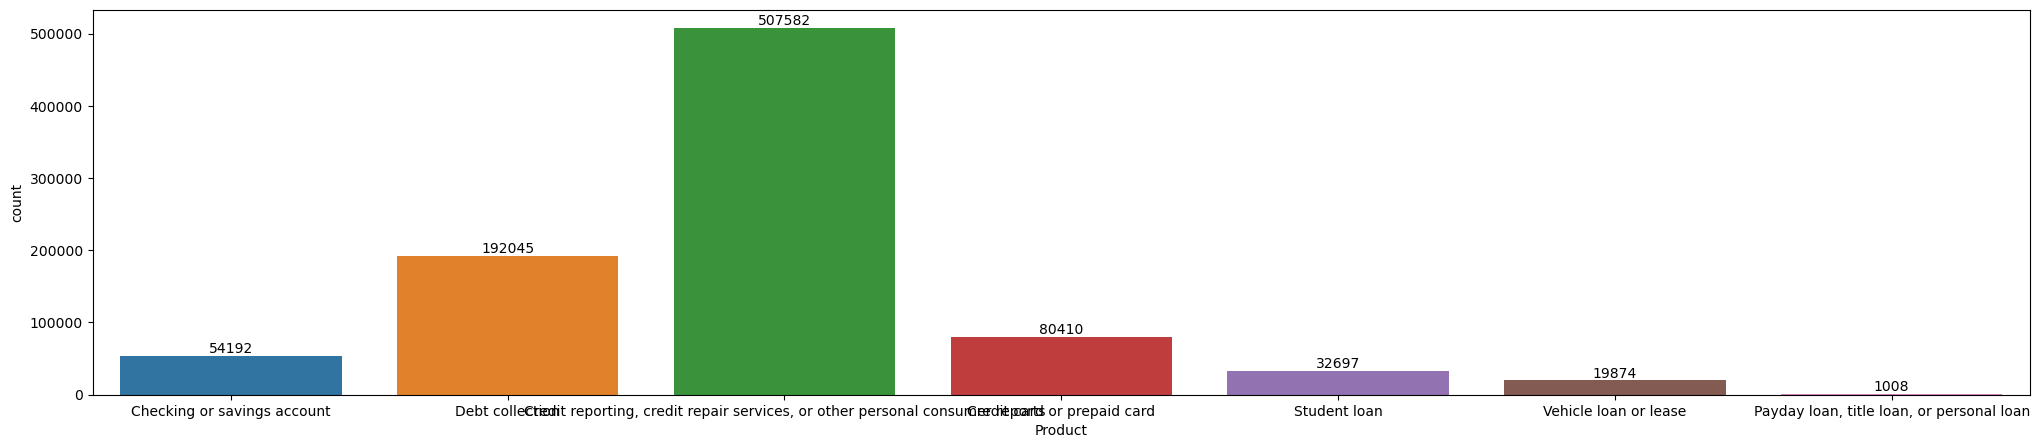

In [9]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, x = data['Product'])
ax.bar_label(ax.containers[0])

### 3.2. Processing Columns

In [10]:
data = data[data['Product'] != 'Payday loan, title loan, or personal loan']
data['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    507582
Debt collection                                                                 192045
Credit card or prepaid card                                                      80410
Checking or savings account                                                      54192
Student loan                                                                     32697
Vehicle loan or lease                                                            19874
Name: Product, dtype: int64

In [9]:
password_len = [len(word) for word in data['Consumer complaint narrative'].str.split('')]
data['password_len'] = pd.DataFrame(password_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['password_len'], palette="crest")

KeyError: 'password'

In [11]:
[len(word) for word in data['Consumer complaint narrative'].str.split(' ')]

In [12]:
for idx, text in enumerate(data['Consumer complaint narrative']):
    print(text)